### GIZ Initial Data Exploration
#### author: Emily Robitschek

Purpose: Before we build any model, we need to be able to take a look at the documents we have.

Some resources: 

#### papers mentioned in project proposal: 
https://medium.com/fiscalnoteworthy/citing-your-sources-79062248f468
https://www2.deloitte.com/us/en/insights/focus/cognitive-technologies/natural-language-processing-examples-in-government-data.html
https://documents1.worldbank.org/curated/en/634591516387264234/pdf/WPS8310.pdf

#### NLP related links: 
- https://spacy.io/usage/spacy-101
- https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
- https://arunm8489.medium.com/getting-started-with-natural-language-processing-6e593e349675
- https://towardsdatascience.com/natural-language-processing-pipeline-decoded-f97a4da5dbb7

### Import libraries

In [1]:
import os
import glob
import time
import json

import scipy
import numpy as np
import pandas as pd

#set up packages for processing data types and for NLP analysis
from collections import OrderedDict
import contractions
import spacy
nlp=spacy.load('en_core_web_sm') #or the multi-language one: spacy.load('xx_ent_wiki_sm')

#graphing/visualization packages: 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Define helper functions for preprocessing

In [2]:
#input data helper functions
def get_docs_df_from_folder(policy_doc_folder):
    """
    Takes in a folder (can also be with different subfolders) with policy-related text documents 
    and gathers txt docs to analyze from those folders and makes a dataframe of their names and paths.
    
    NOTE: If want to preserve names and paths of the documents and make them easily searchable, it might be useful 
    to export the dictionary/keep that as well to add more summary information about the document for instance. 
    """
    #get the paths and file names
    policy_doc_names, policy_doc_paths = list_docs(policy_doc_folder)
    #print the number of docs and the names of some of them 
    print(("There are %d policy docs" % (len(policy_doc_names))),
          "Some of the policy docs include: ", policy_doc_names[:10])

    policy_doc_dict = {'policy_doc_names': policy_doc_names, 'policy_doc_paths': policy_doc_paths}
    policy_doc_df = pd.DataFrame(data=policy_doc_dict, dtype='string')
    #set index as policy doc names (can clean up/add other column with a neater name without the .txt pieces later)
    policy_doc_df['policy_doc_name_clean'] = (policy_doc_df['policy_doc_names']
                                              .apply(lambda x: x.split('.txt')[0].split('.pdf.ocr')[0]))
    policy_doc_df.index = policy_doc_df['policy_doc_names']
    del policy_doc_df['policy_doc_names'] #remove duplicate column
    return policy_doc_df

def list_docs(folder):
    """
    Generates a list of document names for reference and tracking. 
    This command currently extracts the .txt documents from all the subfolders of a parent folder, 
    and filters out the ones containing source information, which we might not want to use in our analysis.
    """
    doc_names = []
    doc_paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.txt') and (file not in ['Source.txt', 'Source Link.txt', 'Source Links.txt']):
                doc_names.append(file)
                doc_paths.append(os.path.join(root, file))  
    return doc_names, doc_paths

#NLP related helper functions
#used these resources: 
#https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/)
#https://realpython.com/natural-language-processing-spacy-python/#how-to-download-models-and-data

def fix_contractions(document): 
    """
    Switches contractions like can't to cannot so potentially important words/pieces of words are 
    removed with punctuation removal.
    """
    # original contracted text
    text = open(document).read()
    
    #creating an empty list
    expanded_words = []    
    for word in text.split():
        #using contractions.fix to expand the shortened words 
        expanded_words.append(contractions.fix(word))   

    expanded_text = ' '.join(expanded_words)
    print('Original text: ', len(text))
    print('Expanded_text: ', len(expanded_text))
    return expanded_text

def is_token_allowed(token):
    '''
        Only allow valid tokens which are not stop words
        and punctuation symbols.
    '''
    if (not token or not token.text.strip() or
        token.is_stop or token.is_punct):
        return False
    return True

def preprocess_token(token):
    # Reduce token to its lowercase lemma form
    return token.lemma_.strip().lower()

def preprocess_doc(doc_path): 
    """
    Applies NLP framework to a document returns the word tokens and sentence tokens.
    NOTE: may want to also return sentences and other objects too depending on the use case
    """
    #remove contracted words and tokenize the document
    tokens = nlp(fix_contractions(doc_path))
    
    #extract list of word tokens
    token_list = [token for token in tokens]
    #print('These are some of the unfiltered tokens: ', tokens[0:50], '\n')

    #find sentences
    sentences = list(tokens.sents)
    for sentence in sentences[:10]:
        print(sentence)
    return tokens, token_list, sentences

def filter_modify_tokens(tokens):
    """
    This function takes a collection of tokens from the nlp() function applied to text 
    and generates a list of filtered tokens that we then convert into a filtered text and 
    collection of filtered tokens.
    
    NOTE: still need to filter out super weird non words and may want to filter numbers and
    may want to find some important accronyms too (so maybe modify this function later)
    """
    #filter tokens, and make lowercase and lemmatize (with preprocess function): 
    filtered_text_list = [preprocess_token(token) for token in 
                       tokens if is_token_allowed(token)]

    filtered_text = ' '.join(filtered_text_list)
    filtered_tokens = nlp(filtered_text)
    return filtered_tokens

def make_filtered_tokens_from_ndc(ndc_dict): 
    """
    Takes an NDC dictionary and processes the topics and keywords for searching within the documents, 
    assuming we are searching for individual words and to process the words in the same way are processing 
    the document text to have the best chance of finding keywords in the documents.
    """
    ndc_dict_processed = dict()
    unique_keywords = []
    for i in range(0, len(list(ndc_dict.keys()))):
        topic = list(ndc_dict.keys())[i]
        keywords = list(ndc_dict.values())[i]
        print(('Original words from the NDC related to %s : ' % (topic)), 
              len(keywords), keywords, '/n')
        #add keywords from topic (key) to list of values and tokenize those values: 
        keywords.append(topic)
        keywords_tokens = nlp(' '.join(keywords))
        #generate a filtered list of keywords using the same token preprocessing we use in the documents
        keywords_tokens_list = [str(token) for token in filter_modify_tokens(keywords_tokens)]
        #filter non-unique words generated by splitting terms with shared words (e.g. two types of 'plan')
        unique_keywords = list(OrderedDict.fromkeys(keywords_tokens_list))
        print(('Filtered words from the NDC related to %s : ' % (topic)),
              len(unique_keywords), unique_keywords, '/n')
        ndc_dict_processed[topic] = unique_keywords
    return ndc_dict_processed

def calculate_word_freq_ndc(word_freq, ndc_dict, key): 
    """
    Input: The word frequencies calculated by the Counter for the whole document (word_freq), 
    the dictionary of ndc key words organized by topic (ndc_dict), and the ndc topic (key).
    Output: Pull out the word frequencies (word_scores) for each of the NDC words associated 
    with a topic (words) for graphing.
    """
    words = ndc_dict[key]
    word_scores = []
    for word in words: 
        word_scores.append(word_freq[word])
    print(("This document has the following number of words related to %s NDCs: " % (key)),
            sum(word_scores), '\n')
    return words, word_scores 

def graph_word_freq_ndc(words, word_scores, ndc_name, doc_name, output_folder):
    """
    Input: The word frequencies (word_scores) for the NDC words associated 
    with a topic (words) for graphing, including the associated NDC topic (ndc_name) and 
    document name (doc_name) to include in graph and file name for output to the output_folder. 
    Output: Bar graph in the output folder of word frequencies for the NDC words associated 
    with a topic/theme.
    """
    #input data
    x=words
    y=word_scores
    x_pos = [i for i, _ in enumerate(x)]
    
    #set plot parameters
    plt.rcParams["figure.figsize"] = ((len(words)/3),4)
    plt.bar(x, y, color='mediumseagreen')
    plt.xlabel("NDC words: %s" % (ndc_name))
    plt.ylabel("Frequency")
    title = ("%s NDC words in: %s" % (ndc_name, doc_name))
    plt.title(title)
    plt.xticks(x_pos, x, rotation=90)
    plt.savefig((graphs_folder + 'bar_chart_%s.pdf' % (title)), 
                bbox_inches='tight')
    plt.show()

### Import data: Keywords from NDCs

In [3]:
#keywords (just for testing purposes - from the policy proposal from GIZ)
policy = ["policy", "integrate", "implement", "committee", "consultation"]
food = ["nutritions", "diets", "farm", "agriculture", "ecology"]
ndc_national_adaption_plan = ["nap", "sector plan", "nccrp", "vulnerable sector", 
                              "geographic vulnerability"]
ndc_climate_change = ["adaption", "program", "projects", "resilience", "institution",
                      "capacity", "response", "budget", "reprioritisation", "development", 
                      "planner", "regulator", "practitioners", "geographical", 
                      "circumstances", "land", "scheme", "authorisation", "system", 
                      "spluma"]
ndc_early_warning = ["system", "vulnerability", "needs", "assessment", "network", "weather",
   "earth", "observation", "academic", "community"]

#keywrods from json file
json_keywords_SA_file = '../ndc_keywords/ndc_south_africa.json'
keywords_SA_dict = None
with open(json_keywords_SA_file, 'r') as f: 
    keywords_SA_dict = json.load(f)
keywords_SA_dict

ndc_dict = make_filtered_tokens_from_ndc(keywords_SA_dict)

Original words from the NDC related to national adaption plan :  5 ['nap', 'sector plan', 'nccrp', 'vulnerable sector', 'geographic vulnerability'] /n
Filtered words from the NDC related to national adaption plan :  9 ['nap', 'sector', 'plan', 'nccrp', 'vulnerable', 'geographic', 'vulnerability', 'national', 'adaption'] /n
Original words from the NDC related to climate change :  14 ['adaption program', 'adaption projects', 'resilience', 'institutional capacity', 'response', 'budget reprioritisation', 'development', 'planner', 'regulator practitioners', 'geographical circumstances', 'land use scheme', 'authorisation system', 'spatial land use management act', 'spluma'] /n
Filtered words from the NDC related to climate change :  26 ['adaption', 'program', 'project', 'resilience', 'institutional', 'capacity', 'response', 'budget', 'reprioritisation', 'development', 'planner', 'regulator', 'practitioner', 'geographical', 'circumstance', 'land', 'use', 'scheme', 'authorisation', 'system', '

In [4]:
#get words directly from NDCs
#
#
#

### Import data: Policy-related documents to analyze

In [5]:
#here is the general folder with the different types of policy documents
policy_doc_folder = '../../giz-policy_tracking_docs/SouthAfrica/Data'
#get df of docs
policy_doc_df = get_docs_df_from_folder(policy_doc_folder)
policy_doc_df.head()

There are 103 policy docs Some of the policy docs include:  ['InSessionSpecialEditionBudget2021.pdf.ocr.txt', 'InSessionVol2Issue10.pdf.ocr.txt', 'InSessionSpecialEditionBudget2021.txt', 'InSessionVol2Issue10.txt', 'InSessionVol2Issue11.txt', 'InSessionSpecialEdition2021.txt', 'InSessionSpecialEdition2021.pdf.ocr.txt', 'InSessionVol2Issue11.pdf.ocr.txt', '2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt', 'Climate_Change_Bill (2018).txt']


,policy_doc_paths,policy_doc_name_clean
policy_doc_names,,
InSessionSpecialEditionBudget2021.pdf.ocr.txt,../../giz-policy_tracking_docs/SouthAfrica/Dat...,InSessionSpecialEditionBudget2021
InSessionVol2Issue10.pdf.ocr.txt,../../giz-policy_tracking_docs/SouthAfrica/Dat...,InSessionVol2Issue10
InSessionSpecialEditionBudget2021.txt,../../giz-policy_tracking_docs/SouthAfrica/Dat...,InSessionSpecialEditionBudget2021
InSessionVol2Issue10.txt,../../giz-policy_tracking_docs/SouthAfrica/Dat...,InSessionVol2Issue10
InSessionVol2Issue11.txt,../../giz-policy_tracking_docs/SouthAfrica/Dat...,InSessionVol2Issue11


### Preprocess data

In [6]:
##lets take a look at the document from South Africa used in the example in the proposal first:
doc_name = '2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt'
##lets try with another document
#test_doc_name = 'InSessionSpecialEditionBudget2021.pdf.ocr.txt'
doc_path = policy_doc_df.loc[doc_name]['policy_doc_paths']

#can also simply specify the first or whichever document in the list by order: 
#(this will be helpful for future versions that involve more interrating over different documents)
i=53
doc_name = policy_doc_df.iloc[i]['policy_doc_name_clean']
doc_path = policy_doc_df.iloc[i]['policy_doc_paths']
print(doc_name, doc_path)
tokens, token_list, sentences = preprocess_doc(doc_path)

environmentquarterly_july_sept2019 ../../giz-policy_tracking_docs/SouthAfrica/Data/Department Forestry, Fisheries _ the Environment Quarterly Magazine/TXT/environmentquarterly_july_sept2019.txt
Original text:  81290
Expanded_text:  80012
www.environment.gov.za : Environment Quarterly i July – September 2019:
The Women Issue EzemVelo Ngenyanga Ntathu Mbango wa kotara Mupo nga Kotaraii Environment Quarterly : July – September 2019www.environment.gov.za :
Environment Quarterly 1 Content ARTICLES IN ENVIRONMENT QUARTERLY THIS ISSUE : July – September 2019 14 22 7 Cover story 4 Women doing excellent work in environment Features 10 Minister and Deputy Minister lead Mandela Day 13
Poster: UNESCO Heritage Sites 14 Waste Khoro 15
Poster: Arbour Month 16
Poster:
Abalone farming and poaching 18 Securing a future for nature in Africa 19
Poster: Producing energy from plant matter 23 Research: Nanomaterials in household products needs attention 24 DEFF signs MoU with Waste Management SA 25 DEFF to p

#### The token object: 
The tokens have all sorts of useful information association with them, for instance their positions (in token.idx) which we can use these later to define windows. See below for example.

In [7]:
for token in token_list[:20]:
    print (token, token.idx)

www.environment.gov.za 0
: 23
Environment 25
Quarterly 37
i 47
July 49
– 54
September 56
2019 66
: 70
The 72
Women 76
Issue 82
EzemVelo 88
Ngenyanga 97
Ntathu 107
Mbango 114
wa 121
kotara 124
Mupo 131


We can see from above that the tokens need to be filtered and it might be useful if the words are all made lowercase and the words are lemmatized so the different forms of a word are recognized as the same thing

In [8]:
filtered_tokens = filter_modify_tokens(tokens)
print('These are some of the filtered tokens: ', filtered_tokens[200:300])

These are some of the filtered tokens:  41 242 environment quarterly july september 2019 editorial head communications albi modise editor erica mathye editorial team salome tsoka tshegofatso ndhlovu veronica mahlaba zibuse ndlovu cover image benedict mlaba design layout brian chapole funeka simelane itumeleng motsepe nkosingiphile madlopha sibusisiwe nxumalo contributors benedict mlaba gaopalelwe moroane koketso modiba nikki kingsley perfect hlongwane russell baloyi ryan peter seipati sentle siziphiwe maxengana tshego letshwiti photography benedict mlaba brian chapole erica mathye gaopalelwe moroane proudly sa siziphiwe maxengana veronica mahlaba zibuse ndlovu meet team find information www.environment.gov.za 086 111 2468 dear valued stakeholder n august south africa celebrate women month mark march union


### Find most common (and unique) words

In [9]:
from collections import Counter
# Remove stop words and punctuation symbols
words = [token.text for token in filtered_tokens]
word_freq = Counter(words)
# 5 commonly occurring words with their frequencies
common_words = word_freq.most_common(30)
print(common_words)

# Unique words
#unique_words = [word for (word, freq) in word_freq.items() if freq == 1]
#print (unique_words)

[('environment', 122), ('ms', 63), ('quarterly', 52), ('minister', 52), ('africa', 52), ('department', 51), ('work', 47), ('waste', 45), ('south', 43), ('2019', 42), ('say', 42), ('management', 39), ('grass', 38), ('woman', 36), ('september', 34), ('july', 33), ('day', 33), ('programme', 33), ('environmental', 32), ('mr', 31), ('coastal', 29), ('country', 29), ('lawn', 29), ('area', 28), ('municipality', 26), ('forestry', 26), ('year', 26), ('climate', 26), ('deff', 25), ('creecy', 25)]


In [10]:
for key in ndc_dict.keys(): 
    print (key)

national adaption plan
climate change
early warning


### Make some plots of the NDC/Thematic key words

Graphing the occurences of national adaption plan words in the document
This document has the following number of words related to national adaption plan NDCs:  47 



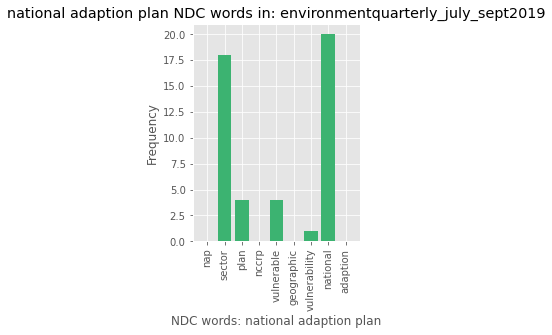

Graphing the occurences of climate change words in the document
This document has the following number of words related to climate change NDCs:  159 



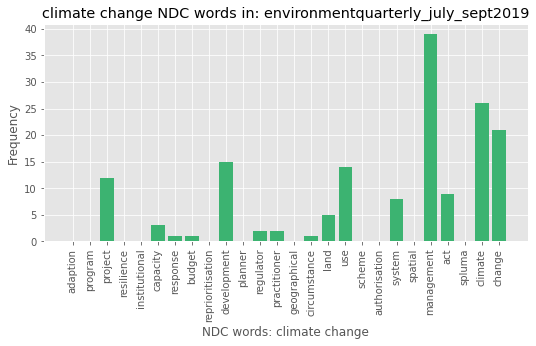

Graphing the occurences of early warning words in the document
This document has the following number of words related to early warning NDCs:  66 



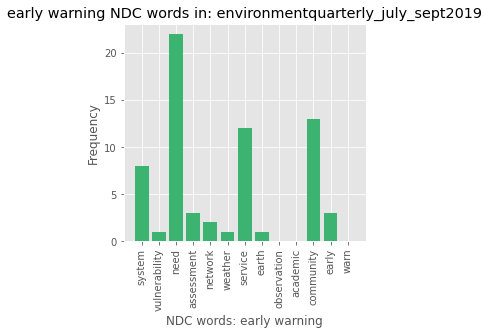

In [11]:
#just to test - need to modularise/make more reproducible and tailor output to be useful across documents
#could also link this back to the df of the documents to output a table with some summary metrics for keywords 
#in eaach document of interest

graphs_folder = '../../outputs/test_plots/bar_charts/'    
    
for key in ndc_dict.keys(): 
    print("Graphing the occurences of %s words in the document" % key)
    words, word_scores = calculate_word_freq_ndc(word_freq, ndc_dict, str(key))
    graph_word_freq_ndc(words, word_scores, str(key), doc_name, graphs_folder) 

### Parts of speech tagging

In [12]:
for token in filtered_tokens[:50]:
    print(token, token.tag_, token.pos_, spacy.explain(token.tag_))
print('\n')
    
nouns = []
adjectives = []
for token in filtered_tokens:
    if token.pos_ == 'NOUN':
        nouns.append(token)
    if token.pos_ == 'ADJ':
        adjectives.append(token)

print('some nouns spacy called in the document include:', '\n', nouns[:50], '\n')
print('some adjectives spacy called in the document include:', '\n', adjectives[:50])

www.environment.gov.za NNP PROPN noun, proper singular
environment NNP PROPN noun, proper singular
quarterly JJ ADJ adjective (English), other noun-modifier (Chinese)
july NNP PROPN noun, proper singular
september NNP PROPN noun, proper singular
2019 CD NUM cardinal number
women NNS NOUN noun, plural
issue NN NOUN noun, singular or mass
ezemvelo NNP PROPN noun, proper singular
ngenyanga NNP PROPN noun, proper singular
ntathu NNP PROPN noun, proper singular
mbango NNP PROPN noun, proper singular
wa NNP PROPN noun, proper singular
kotara NNP PROPN noun, proper singular
mupo NNP PROPN noun, proper singular
nga RB ADV adverb
kotaraii NNP PROPN noun, proper singular
environment NNP PROPN noun, proper singular
quarterly JJ ADJ adjective (English), other noun-modifier (Chinese)
july NNP PROPN noun, proper singular
september NNP PROPN noun, proper singular
2019www.environment.gov.za CD NUM cardinal number
environment NNP PROPN noun, proper singular
quarterly RB ADV adverb
1 CD NUM cardinal num

In [13]:
doc_name

'environmentquarterly_july_sept2019'